#  <center>基于Transformer实现英语到西班牙语的翻译任务</center>


* 作者信息:
    * Github：[2017040264](https://github.com/2017040264)
    * AiStudio：[月光下的独孤亮](https://aistudio.baidu.com/aistudio/personalcenter/thirdview/689988)
    * 摘要：基于Transformer实现英语到西班牙语的机器翻译任务
* 更新日期：2022.12.19





# 1.项目背景
在本项目中，我们将构建一个Sequence-to-sequence的 Transformer 模型，并在英语到西班牙语的机器翻译任务中对其进行训练。
* Sequence-to-sequence:
机器翻译是序列转换模型的一个核心问题，其输入和输出都是长度可变的序列。为了处理这种类型的输入和输出，研究人员设计出一个包含两个主要组件的架构：
    * 第一个组件是一个编码器（encoder）：它接受一个长度可变的序列作为输入，并将其转换为具有固定形状的编码状态。
    * 第二个组件是解码器（decoder）：它将固定形状的编码状态映射到长度可变的序列。

这种架构被称为编码器-解码器（encoder-decoder）架构，如下图所示：

![](https://ai-studio-static-online.cdn.bcebos.com/a7cadcd296924fec8f50146faa7d0c1db5c39f0712474be6a3dfe1b44d3270c9)

* Transformer:
Transformer是Sequence-to-sequence架构的一种实例，其诞生于2017年的《Attention is all you need》,诞生之初该模型就展示出了强大的魅力，刷新了NLP领域的大部分SOTA。现如今在Transformer在CV领域应用也得到了十分广泛的应用。Transformer的框架图如下：

![](https://ai-studio-static-online.cdn.bcebos.com/ca0931928b4a41af97a318f66957767c9ffda9b248634f4182cfda80e6a3923a)



* 机器翻译：
机器翻译（machine translation）指的是将序列从一种语言自动翻译成另一种语言。事实上，这个研究领域可以追溯到数字计算机发明后不久的20世纪40年代， 特别是在第二次世界大战中使用计算机破解语言编码。几十年来，在使用神经网络进行端到端学习的兴起之前，统计学方法在这一领域一直占据主导地位。因为统计机器翻译（statisticalmachine translation）涉及了翻译模型和语言模型等组成部分的统计分析，因此基于神经网络的方法通常被称为 `神经机器翻译（neuralmachine translation）`，用于将两种翻译模型区分开来。




# 2.环境设置

我们需要的依赖主要有：
* paddle系列：组装数据集、搭建模型框架
* padldenlp系列：百度提供的数据处理框架
* numpy:  NumPy (Numerical Python) 是 Python 语言的一个扩展程序库，支持大量的维度数组与矩阵运算，此外也针对数组运算提供大量的数学函数库
* collections: 主要使用Counter，快速构建语料库字典
* string: 字符串库，我们要使用标点符号集合
* functools：主要使用partial，用于数据集的构建工作
* random: 随机函数库
* matplotlib.pyplot：画图使用

In [1]:
import paddle
import paddlenlp
from paddle.io import Dataset
from paddlenlp.data import Vocab
from paddlenlp.metrics import BLEU
import numpy as np
import string
import random
import matplotlib.pyplot as plt
from functools import partial
from collections import Counter

print(paddle.__version__)

2.4.0


# 3.数据集
使用Anki提供的`English-to-Spanish`翻译数据集,下载地址为：[English-to-Spanish数据集](http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip)。该数据集总共包含118964条（English,Spanish）语句对。示例如下：


| English | Spanish | 
| -------- | -------- |
| Go on home.    |Vete a casa.  | 
| I can jump.   |Puedo saltar.|




## 3.1 加载数据集
数据集的加载有两种方式：





1. 通过链接自行下载，该方法可能存在下载速度慢等不便利的情况，不推荐。

In [2]:
# 自行下载数据集

# from paddle.utils.download import get_path_from_url
# URL = "http://storage.googleapis.com/download.tensorflow.org/data/spa-eng.zip"
# get_path_from_url(URL, "./data")
# text_file='data/spa-eng/spa.txt' # 数据集路径

2. 我们已经下载好并上传至AiStudio平台，使用方便，强烈推荐。我们的数据集地址：[【NLP】English-Spanish](https://aistudio.baidu.com/aistudio/datasetdetail/173968/0)

In [3]:
# 使用我们提供的数据集

text_file='data/data173968/spa.txt' # 数据集路径

## 3.2 添加[start] token与 [end] token


* 为西班牙语添加`[start]`与 `[end]`
* `[start]`表示西班牙语的开始
* `[end]`表示西班牙语的结束

In [4]:
with open(text_file) as f:
    lines = f.read().split("\n")[:-1]
text_pairs = []
for line in lines:
    eng, spa = line.split("\t")
    spa = "[start] " + spa + " [end]"
    text_pairs.append((eng, spa))

* 英语和添加`[start]`及`[end]`后的西班牙语展示：

In [5]:
for _ in range(5):
    print(random.choice(text_pairs))

('If you wish, you can go.', '[start] Si quieres, puedes ir. [end]')
('They were arguing about money.', '[start] Ellos estaban discutiendo por dinero. [end]')
('Tom now works for Mary.', '[start] Ahora Tom trabaja para Mary. [end]')
('It seems we are in the same boat.', '[start] Parece que vamos en el mismo bote. [end]')
("I don't think what we did helped.", '[start] No creo que lo que hicimos ayudase. [end]')


## 3.3划分数据集
1. 随机打乱数据集
2. 划分数据集，训练集：验证集：测试集 = 8 : 1 : 1

In [6]:
random.shuffle(text_pairs)
num_val_samples = int(0.1 * len(text_pairs))
num_train_samples = len(text_pairs) - 2 * num_val_samples
train_pairs = text_pairs[:num_train_samples]
val_pairs = text_pairs[num_train_samples : num_train_samples + num_val_samples]
test_pairs = text_pairs[num_train_samples + num_val_samples :]

print(f"{len(text_pairs)} total pairs")
print(f"{len(train_pairs)} training pairs")
print(f"{len(val_pairs)} validation pairs")
print(f"{len(test_pairs)} test pairs")

118964 total pairs
95172 training pairs
11896 validation pairs
11896 test pairs


In [7]:
train_eng_texts = [pair[0] for pair in train_pairs]
train_spa_texts = [pair[1] for pair in train_pairs]

val_eng_texts = [pair[0] for pair in val_pairs]
val_spa_texts = [pair[1] for pair in val_pairs]

test_eng_texts = [pair[0] for pair in test_pairs]
test_spa_texts = [pair[1] for pair in test_pairs]

## 3.4 数据集预处理


* 定义英语和西班牙语的预处理函数
* save_punctuation=True:  保留标点符号，在标点之前（之后）加空格；
* save_punctuation=False: 删除所有的标点

In [8]:
def pre_process(datas, save_punctuation=False):
    dataset=[]
    # 定义标点符号集合
    
    strip_chars = string.punctuation + "¿¡" 
    strip_chars = strip_chars.replace("[", "")
    strip_chars = strip_chars.replace("]", "")

    for i in range(len(datas)):
        lowercase=datas[i].lower() # 全部转为小写

        out=""
        if save_punctuation:
            # 在标点符号之前加空格，需注意有特殊情况
            for low in lowercase:
                if low in strip_chars:
                    if low=="¿"or low=="¡": # 分别表示西班牙语的反问号、反叹号
                        out+=low+" "
                    else:
                        out+=" "+low
                else:
                    out+=low
        else:
            # 也可以选择删除除所有的标点
            for low in lowercase:
                if low not in strip_chars:
                    out+=low
                    
        dataset.append(out)
    return dataset

* 分别处理训练集、测试集、验证集上的英语和西班牙语数据

In [9]:
train_eng_texts_pre=pre_process(train_eng_texts)
train_spa_texts_pre=pre_process(train_spa_texts)

val_eng_texts_pre=pre_process(val_eng_texts)
val_spa_texts_pre=pre_process(val_spa_texts)

test_eng_texts_pre=pre_process(test_eng_texts)
test_spa_texts_pre=pre_process(test_spa_texts)

print("预处理结果展示：")
print("英语：标准化处理之前：",train_eng_texts[0])
print("英语：标准化处理之后：",train_eng_texts_pre[0])

print("西班牙语：标准化处理之前：",train_spa_texts[0])
print("西班牙语：标准化处理之后：",train_spa_texts_pre[0])

预处理结果展示：
英语：标准化处理之前： I can go there on foot.
英语：标准化处理之后： i can go there on foot
西班牙语：标准化处理之前： [start] Puedo llegar allí a pie. [end]
西班牙语：标准化处理之后： [start] puedo llegar allí a pie [end]


## 3.5 统计句子长度
* 通过统计句子长度进而更加合理的设置网络的输入向量的长度

#### 3.5.1 英语句子长度

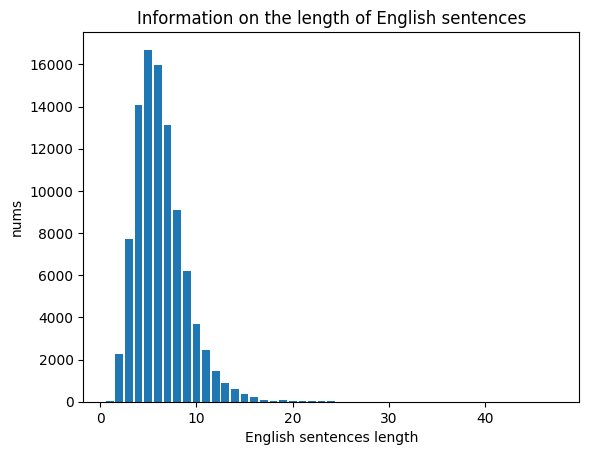

In [10]:
dicta=dict()
for text in train_eng_texts_pre:
    lent=len(text.split())
    if lent in dicta.keys():
        dicta[lent]+=1
    else:
        dicta[lent]=1
lita=sorted(dicta.items(), key = lambda x:x[0], reverse = True)

x=[l[0] for l in lita]
y=[l[1] for l in lita]
plt.bar(x, y)  
plt.xlabel('English sentences length')
plt.ylabel('nums')
plt.title('Information on the length of English sentences')
plt.show()

#### 3.5.2 西班牙语句子长度

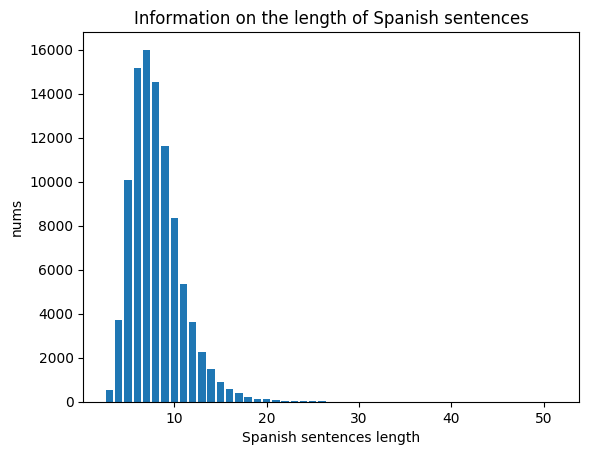

In [11]:
dicta=dict()
for text in train_spa_texts_pre:
    lent=len(text.split())
    if lent in dicta.keys():
        dicta[lent]+=1
    else:
        dicta[lent]=1
lita=sorted(dicta.items(), key = lambda x:x[0], reverse = True)

x=[l[0] for l in lita]
y=[l[1] for l in lita]
plt.bar(x, y)  
plt.xlabel('Spanish sentences length')
plt.ylabel('nums')
plt.title('Information on the length of Spanish sentences')
plt.show()

* 从统计信息可以看出，绝大部分英语和西班牙语的句子长度都在20以下，因此我们可以把输入向量的长度统一设置为20

## 3.6 用训练集分别构造英语和西班牙语的语料库

* 定义语料库创建函数

In [12]:
def build_cropus(data):
    crpous=[]
    for i in range(len(data)):
        cr=data[i].strip().lower()
        cr=cr.split()
        crpous.extend(cr)
    return crpous


* 用训练集分别创建**英语**和**西班牙语**语料库

In [13]:
eng_crpous=build_cropus(train_eng_texts_pre)
spa_crpous=build_cropus(train_spa_texts_pre)

print(eng_crpous[:3])
print(spa_crpous[:3])

['i', 'can', 'go']
['[start]', 'puedo', 'llegar']


* 定义根据给定的词汇量并按照词汇出现的频率构造词典的函数

In [14]:
def build_dict(corpus, vocab_size):

    # 1.首先统计每个不同词的频率（出现的次数），使用一个词典记录
    word_freq_dict = dict()
    for word in corpus:
        if word not in word_freq_dict:
            word_freq_dict[word] = 0
        word_freq_dict[word] += 1

    # 2.将词典中的词，按照出现次数排序，出现次数越高，排序越靠前
    word_freq_dict = sorted(word_freq_dict.items(), key = lambda x:x[1], reverse = True)


    # 3.构造2个不同的词典
    # 每个词到id的映射关系：word2id_dict
    # 每个id到词的映射关系：id2word_dict
    word2id_dict = {'<pad>':0,'<unk>':1}
    id2word_dict = {0:'<pad>',1:'<unk>'}

    # 4.按照频率，从高到低，开始遍历每个单词，并为这个单词构造一个独一无二的id
    i = 2
    for word, freq in word_freq_dict:
        if i < vocab_size:
            word2id_dict[word] = i
            id2word_dict[i] = word
            i += 1
        else: # 超过指定的词汇量，指向<unk>
            word2id_dict[word] = 1
    return word2id_dict, id2word_dict

* 定义词汇量，建议定义的大一些，减少oov(out of vocabulary)词汇，oov词汇一般使用`<unk>`表示。英语词汇量和西班牙语词汇量上限可以分开定义，也可以共享上限。我们可以统计出我们使用的[English-to-Spanish数据集](https://aistudio.baidu.com/aistudio/datasetdetail/173968/0)中英语词汇有12089个，西班牙语词汇有22533个，如果共享词汇量上限，那么
    - 如果设置的词汇量小于12089，则英语和西班牙语中都会出现`<unk>`
    - 如果设置的词汇量大于12089而小于22533，则英语中不会有`<unk>`,而西班牙语中会出现`<unk>`
    - 如果设置的词汇量大于22533，则英语和西班牙语中都不会出现`<unk>`
* 词汇量大小的设置会影响预测结果，在算力足够的情况下，词汇量设置的大一些比较好。
* 分别获取英语、西班牙语的token和id的转换词典


In [15]:
vocab_size = 25000  #共享词汇量上限
eng2id_dict,id2eng_dict=build_dict(eng_crpous, vocab_size)
spa2id_dict,id2spa_dict=build_dict(spa_crpous, vocab_size)

print("我们设置的英语总词汇上限为：",vocab_size,"\t总的英语词汇量为：",len(eng2id_dict),"\t我们实际使用的英语词汇量为",len(id2eng_dict))
print("我们设置的西班牙语总词汇上限为：",vocab_size,"\t总的西班牙语词汇量为：",len(spa2id_dict),"\t我们实际使用的西班牙语词汇量为",len(id2spa_dict))

我们设置的英语总词汇上限为： 25000 	总的英语词汇量为： 12655 	我们实际使用的英语词汇量为 12655
我们设置的西班牙语总词汇上限为： 25000 	总的西班牙语词汇量为： 23791 	我们实际使用的西班牙语词汇量为 23791


## 3.7 输入向量化
* maxlen是我们进行向量长度，超过该长度的向量被截断（弃尾）；不足该长度的进行padding（padding值为0）


In [16]:
def build_tensor(data, dicta, maxlen):
    tensor=[]
    for i in range(len(data)):
        subtensor=[]
        lista=data[i].split()
        for j in range(len(lista)):
            index=dicta.get(lista[j])
            # 对于训练解和测试集，可能会出现未在词表中的词汇，此时index会返回None,此时我们指定index=1,即指向<unk>
            if index==None:
                index=1
            subtensor.append(index)
    
        if len(subtensor) < maxlen:
            # 0是我们进行padding的向量值
            subtensor += [0] * (maxlen - len(subtensor))
        else:
            subtensor=subtensor[:maxlen]

        tensor.append(subtensor)
    return np.array(tensor)

In [17]:
sequence_length = 20 # 语句长度我们统一设置为20，可以依据3.5小结的统计信息分开设置

train_eng_tensor=build_tensor(train_eng_texts_pre, eng2id_dict, sequence_length)
val_eng_tensor=build_tensor(val_eng_texts_pre, eng2id_dict, sequence_length)
test_eng_tensor=build_tensor(test_eng_texts_pre, eng2id_dict, sequence_length)

train_spa_tensor=build_tensor(train_spa_texts_pre, spa2id_dict, sequence_length)
val_spa_tensor=build_tensor(val_spa_texts_pre, spa2id_dict, sequence_length)
test_spa_tensor=build_tensor(test_spa_texts_pre, spa2id_dict, sequence_length)

## 3.8 封装数据集



* 使用paddle.io.Dataset 封装数据集

In [18]:
class MyDataset(Dataset):
    """
    步骤一：继承paddle.io.Dataset类
    """
    def __init__(self, eng, spa):
        """
        步骤二：实现构造函数，定义数据集大小
        """
        super(MyDataset, self).__init__()
        self.eng = eng
        self.spa = spa

    def __getitem__(self, index):
        """
        步骤三：实现__getitem__方法，定义指定index时如何获取数据，并返回单条数据（训练数据，对应的标签）
        """
        return self.eng[index], self.spa[index]

    def __len__(self):
        """
        步骤四：实现__len__方法，返回数据集总数目
        """
        return self.eng.shape[0]



* 定义对每个minibatch的数据集进行处理的函数
* padid=0,0是`<pad>`字段的对应的值，与3.6中我们的字典设计对应
* 该函数返回值的含义：
    - 第一个返回值：英语输入向量，shape=[batchsize,sequence_length]
    - 第二个返回值：西班牙语输入向量，shape=[batchsize,sequence_length-1],第二个维度是`sequence_length-1`,因为我们使用`teacher force`技巧进行训练。实际上我是取的**前**`sequence_length-1`个向量。
    - 第三个返回值：西班牙语目标向量，shape=[batchsize,sequence_length-1,1],第二个维度也是`sequence_length-1`,因为我们使用`teacher force`技巧进行训练。实际上我是取的**后**`sequence_length-1`个向量。此外，我们额外增加了一个维度，用于loss的计算。
    - 第四个返回值：用于消除padding位置对loss的影响，主要在我们的自定义loss中进行使用。

In [19]:
def prepare_input(inputs, padid=0):
    src = np.array([inputsub[0] for inputsub in inputs])
    trg = np.array([inputsub[1] for inputsub in inputs])
    trg_mask = (trg[:,:-1] != padid).astype(paddle.get_default_dtype())
    return src, trg[:,:-1], trg[:, 1:, np.newaxis], trg_mask

* 设置batchsize
* 使用paddle.io.DataLoader 封装用于训练的minibatch数据

In [20]:
BATCH_SIZE=64 

train_dataset = MyDataset(train_eng_tensor, train_spa_tensor)
train_loader = paddle.io.DataLoader(train_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = True, collate_fn = partial(prepare_input))

val_dataset = MyDataset(val_eng_tensor, val_spa_tensor)
val_loader = paddle.io.DataLoader(val_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = True, collate_fn = partial(prepare_input))

test_dataset = MyDataset(test_eng_tensor, test_spa_tensor)
test_loader = paddle.io.DataLoader(test_dataset, batch_size = BATCH_SIZE, shuffle = True, drop_last = True, collate_fn = partial(prepare_input))

# 4.模型组网



In [21]:
# 为方便调试网络，我们提前定义一些参数
embed_dim=256 # 词嵌入embedding的维度
latent_dim=2048 # feed forward 前馈神经网络的相关参数
num_heads=8 # 多头注意力机制的‘头’数

## 4.1 输入处理
Transformer的输入部分使用的是词嵌入(word embedding)和位置编码(positional encoding)的结合。Transformer模型并不包括任何的循环或卷积网络，所以模型添加了位置编码，为模型提供一些关于单词在句子中绝对位置的信息。这个位置编码的具体计算方法有很多种，论文中的计算方法如下：
$$
PE\left( pos,2i \right) =\sin \left( pos/10000^{2i/embed\_dim} \  \right) 
$$

$$
PE\left( pos,2i+1 \right) =\cos \left( pos/10000^{2i/embed\_dim}\  \right) 
$$


其中pos是指当前token在句子中的位置，i是指向量中每个值的index，可以看出，在偶数位置，使用正弦编码，在奇数位置，使用余弦编码。

In [22]:
class TransformerEmbedding(paddle.nn.Layer):
    def __init__(self, sequence_length, vocab_size, embed_dim):
        super(TransformerEmbedding, self).__init__()
        self.token_embeddings = paddle.nn.Embedding(num_embeddings = vocab_size, embedding_dim = embed_dim)
        self.position_embeddings = self.get_position_embedding(sequence_length, embed_dim)

    def forward(self, inputs):
        seq_len = inputs.shape[1]
        embedded_tokens = self.token_embeddings(inputs)
        embedded_positions = self.position_embeddings
        return embedded_tokens + embedded_positions[:, :seq_len, :]

    def compute_mask(self, inputs, mask = None):
        return paddle.not_equal(inputs, 0)
    
    def get_angles(self,pos,i,d_model):
        angle_rate = 1 / np.power(10000, (2 * (i // 2))/np.float32(d_model))
        return pos * angle_rate

    def get_position_embedding(self, sentence_length, d_model):
        angle_rads=self.get_angles(np.arange(sentence_length)[:, np.newaxis],
                            np.arange(d_model)[np.newaxis, :],
                            d_model)
        sines=np.sin(angle_rads[:,0::2])
        cosines=np.cos(angle_rads[:,1::2])
        
        position_embedding=np.concatenate([sines,cosines], axis = -1)
        position_embedding=paddle.to_tensor(position_embedding[np.newaxis, ...])
        
        return paddle.cast(position_embedding, dtype = 'float32')

## 4.2 Encoder
Encoder部分主要包含了多头注意力机制、归一化层以及前馈神经网络。输入会依次经过多头注意力模块、归一化层构成的残差模块、前馈神经网络模块、归一化层构成的残差模块。
* 多头注意力机制（MultiHeadAttention）：使用`paddle.nn.MultiHeadAttention`实现多头注意力机制，需要注意其掩码attn_mask需要的shape是[batch_szie,num_heads,sequence_legth,sequence_legth]
* 前馈神经网络（Feed Forward）：输入经过MultiHeadAttention层后，经过一层feed forward层。模型中的feed forward，采用的是一种posion-wise feed-forward的方法，即先对输入加一个全连接网络，之后使用Relu激活，之后再加一个全连接网络。
* 残差网络：由归一化（LayerNorm）后的结果与之前时刻的输入相加组成。LayerNorm会在每一个样本上计算均值和方差。


In [23]:
class TransformerEncoder(paddle.nn.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads):
        super(TransformerEncoder, self).__init__()
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = paddle.nn.MultiHeadAttention(num_heads = num_heads, embed_dim = embed_dim, dropout = 0.1)

        
        self.dense_proj =paddle.nn.Sequential(
            paddle.nn.Linear(embed_dim, dense_dim), 
            paddle.nn.ReLU(),
            paddle.nn.Linear(dense_dim, embed_dim) )

        self.layernorm_1 = paddle.nn.LayerNorm(embed_dim)
        self.layernorm_2 = paddle.nn.LayerNorm(embed_dim)
        

    def forward(self, inputs):
        attention_output = self.attention(query = inputs, value = inputs, key = inputs)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

## 4.3 Decoder
编码器含有两个多头注意力模块，第一个是带序列掩码的多头注意力模块，用于处理西班牙语的输入；第二个多头注意力模块是用于处理编码器的输出和前一个多头注意力机制的输出。输入在编码器其中会依次经过带序列掩码的多头注意力模块、归一化层构成的残差模块、多头注意力模块、归一化层构成的残差模块、前馈神经网络模块、归一化层构成的残差模块。
* 序列掩码：为了使得 decoder 不能看见未来的信息。也就是对于一个序列，在 time_step 为 t 的时刻，我们的解码输出应该只能依赖于 t 时刻之前的输出，而不能依赖 t 之后的输出。因此我们需要想一个办法，把 t 之后的信息给隐藏起来。做法是产生一个上三角矩阵，上三角的值全为0。把这个矩阵作用在每一个序列上，就可以达到我们的目的。


In [24]:
class TransformerDecoder(paddle.nn.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads):
        super(TransformerDecoder, self).__init__()
        self.embed_dim = embed_dim
        self.latent_dim = latent_dim
        self.num_heads = num_heads
        self.attention_1 = paddle.nn.MultiHeadAttention(num_heads = num_heads, embed_dim = embed_dim)

        self.attention_2 = paddle.nn.MultiHeadAttention(num_heads = num_heads, embed_dim = embed_dim)

        self.dense_proj = paddle.nn.Sequential(
            paddle.nn.Linear(embed_dim, latent_dim), 
            paddle.nn.ReLU(),
            paddle.nn.Linear(latent_dim, embed_dim) )

        self.layernorm_1 = paddle.nn.LayerNorm(embed_dim)
        self.layernorm_2 = paddle.nn.LayerNorm(embed_dim)
        self.layernorm_3 = paddle.nn.LayerNorm(embed_dim)
        

    def forward(self, inputs, encoder_outputs):
        causal_mask = self.get_causal_attention_mask(inputs) #[batch_size, equence_length, sequence_length]
      
        attention_output_1 = self.attention_1(query = inputs, value = inputs, key = inputs, attn_mask = causal_mask)# attn_mask: [batch_size, n_head, sequence_length, sequence_length]
        out_1 = self.layernorm_1(inputs + attention_output_1)

        attention_output_2 = self.attention_2(query = out_1, value = encoder_outputs, key = encoder_outputs)
        out_2 = self.layernorm_2(out_1 + attention_output_2)

        proj_output = self.dense_proj(out_2)
        return self.layernorm_3(out_2 + proj_output)

    def get_causal_attention_mask(self, inputs):
        input_shape = inputs.shape
        batch_size, sequence_length = input_shape[0], input_shape[1]
        i = paddle.arange(sequence_length)[:, np.newaxis]
        j = paddle.arange(sequence_length)
        mask = paddle.cast(i >= j, dtype = "int32") #[sequence_length, sequence_length]
        mask = paddle.reshape(mask, (1, 1, input_shape[1], input_shape[1])) #[1, equence_length, sequence_length]
        mult = paddle.concat([paddle.to_tensor(64, dtype = 'int32'), paddle.to_tensor([1, 1, 1], dtype = "int32")], axis = 0,) #[batch_size,1,1]
        return paddle.tile(mask, mult) #[batch_size, equence_length, sequence_length]

## 4.4 搭建Transformer模型
![](https://ai-studio-static-online.cdn.bcebos.com/ca0931928b4a41af97a318f66957767c9ffda9b248634f4182cfda80e6a3923a)

我们搭建Transformer模型主要包含以下模块：
* 编码器输入的词嵌入与位置编码处理模块
* 编码器模块（N=1）
* 解码器输入的词嵌入与位置编码处理模块
* 解码器模块（N=1）
* 线性输出层

按照图示，Transformer还应该有一层softmax将模型的预测结果归一化，我们在loss函数中实现该操作。

In [29]:
class Transformer(paddle.nn.Layer):
    def __init__(self, embed_dim, latent_dim, num_heads, sequence_length, vocab_size):
        super(Transformer, self).__init__()

        self.ps1=TransformerEmbedding(sequence_length, vocab_size, embed_dim)
        self.encoder=TransformerEncoder(embed_dim, latent_dim, num_heads)

        self.ps2=TransformerEmbedding(sequence_length, vocab_size, embed_dim)
        self.decoder=TransformerDecoder(embed_dim, latent_dim, num_heads) 

        self.drop=paddle.nn.Dropout(p = 0.5)
        self.lastLinear=paddle.nn.Linear(embed_dim, vocab_size)

    def forward(self, encoder_inputs, decoder_inputs):
        # 编码器
        encoder_emb=self.ps1(encoder_inputs)
        encoder_outputs=self.encoder(encoder_emb)

        # 解码器
        deocder_emb=self.ps2(decoder_inputs)
        decoder_outputs=self.decoder(deocder_emb, encoder_outputs)

        # dropout
        out=self.drop(decoder_outputs)

        #最后输出
        out=self.lastLinear(out)

        return out

trans=Transformer(embed_dim, latent_dim, num_heads, sequence_length, vocab_size)
paddle.summary(trans, input_size = [(64,20),(64,20)], dtypes = 'int32')

--------------------------------------------------------------------------------------------
     Layer (type)               Input Shape               Output Shape         Param #    
     Embedding-5                 [[64, 20]]              [64, 20, 256]        6,400,000   
TransformerEmbedding-5           [[64, 20]]              [64, 20, 256]            0       
      Linear-35               [[64, 20, 256]]            [64, 20, 256]         65,792     
      Linear-36               [[64, 20, 256]]            [64, 20, 256]         65,792     
      Linear-37               [[64, 20, 256]]            [64, 20, 256]         65,792     
      Linear-38               [[64, 20, 256]]            [64, 20, 256]         65,792     
 MultiHeadAttention-7                []                  [64, 20, 256]            0       
     LayerNorm-11             [[64, 20, 256]]            [64, 20, 256]           512      
      Linear-39               [[64, 20, 256]]            [64, 20, 2048]        526,336  

{'total_params': 22118824, 'trainable_params': 22118824}

# 5.模型训练与评估

## 5.1 自定义loss函数
* 自定义loss函数的目的是将消除填充位置对loss的影响
* softmax_with_cross_entropy是softmax交叉熵损失函数。该函数会将 softmax 操作、交叉熵损失函数的计算过程进行合并，从而提供了数值上更稳定的梯度值。

In [26]:
class CrossEntropy(paddle.nn.Layer):
    def __init__(self):
        super(CrossEntropy,self).__init__()

    def forward(self,pre,real,trg_mask):

        # 返回的数据类型与pre一致，除了axis维度(未指定则为-1)，其他维度也与pre一致
        # logits=pre,[batch_size,sequence_len,word_size],猜测会进行argmax操作，[batch_size,sequence_len,1]
        # 默认的soft_label为False，lable=real,[bacth_size,sequence_len,1]
        cost=paddle.nn.functional.softmax_with_cross_entropy(logits = pre, label = real, soft_label = False)
        
        # 删除axis=2 shape上为1的维度
        # 返回结果的形状应为 [batch_size,sequence_len]
        cost=paddle.squeeze(cost, axis = [2])

        # trg_mask 的形状[batch_size,suqence_len]
        # * 这个星号应该是对应位置相乘，返回结果的形状 [bathc_szie,sequence_len]
        masked_cost=cost * trg_mask

        return paddle.mean(masked_cost)

## 5.2 训练与验证
* 定义训练的轮数epochs
* 实例化模型类并使用paddle.Model进行封装
* 实例化NoamDecay类，实现动态学习率
* Adam优化器
* 使用自定义的loss函数
* 验证结果的Accuracy

In [ ]:
epochs = 100   
trans=Transformer(embed_dim, latent_dim, num_heads, sequence_length, vocab_size)
model=paddle.Model(trans)

scheduler = paddle.optimizer.lr.NoamDecay(d_model = latent_dim, warmup_steps = 100, verbose = False) #动态调整学习率 
model.prepare(optimizer = paddle.optimizer.Adam(learning_rate = scheduler, parameters = model.parameters()),
              loss = CrossEntropy(),
              metrics = paddle.metric.Accuracy())

model.fit(train_data = train_loader, 
          epochs = epochs,
          eval_data = val_loader,
          verbose = 2,
          save_dir = './savemodel',
          save_freq = 10,
          log_freq = 100,
          callbacks = [paddle.callbacks.VisualDL('./log')])

100个epoch下的loss与Accuracy曲线图：


![](https://ai-studio-static-online.cdn.bcebos.com/5d3d36cec8b0412092cf086eddf8f03d3de23a19a0774a0eb19582beac8ab4e8)



# 6. 结果预测
使用测试集进行结果的预测，并计算BLEU得分。


In [28]:
bleu = BLEU()
for data in test_loader():
    inputs = data[:2]
    result = model.predict_batch(inputs)[0] #[64,19,23517]
    result = np.argmax(np.array(result), axis = -1) #[64,19]
    
    for i in range(2): #仅展示2条预测结果
    #for i in range(len(result)):#展示一个batch的结果
        eng = [id2eng_dict[id]+' ' for id in data[0][i].tolist() if id !=0]
        spa_real = [id2spa_dict[id]+' ' for id in data[1][i][1:].tolist() if id !=0 and id !=3]
        spa_pre = [id2spa_dict[id]+' ' for id in result[i] if id !=0 and id !=3]
        bleu_score = bleu.add_inst(spa_real, [spa_pre])
        sequence = "英语："+"".join(eng)+"\n真实的西班牙语: "+"".join(spa_real)+"\n预测的西班牙语 "+"".join(spa_pre) +"\nBLEU:"+str(bleu.score())+"\n**************\n"
        bleu.reset()
        print(sequence)
    break

英语：who ate the bread 
真实的西班牙语: quién se comió el pan 
预测的西班牙语 quién se comió el pan 
BLEU:1.0
**************

英语：because of the flood it was a bad <unk> 
真实的西班牙语: debido a la inundación fue una mala cosecha de arroz 
预测的西班牙语 debido a la inundación fue una mala costumbre diamantes 
BLEU:0.6389431042462724
**************

